In [1]:
!pip install pycaret[full]
!pip install pycaret-ts-alpha
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install --upgrade pycaret


  Using cached pycaret_ts_alpha-3.0.0.dev1649017462-py3-none-any.whl (468 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached pycaret_ts_alpha-3.0.0.dev1648160839-py3-none-any.whl (520 kB)
  Using cached gensim-3.8.3.tar.gz (23.4 MB)
  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [58 lines of output]
      /anaconda/envs/azureml_py38/lib/python3.10/site-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_b

In [2]:
import pyodbc
import pandas as pd
import jinja2
import pycaret
from pycaret.classification import *

In [3]:
server = 'techentdec.database.windows.net'  
database = 'QAECECRM_dec'                   
username = 'dbadmin'                
password = 'DashTech1234'         
connection_string = f"""
Driver={{ODBC Driver 17 for SQL Server}};
Server={server};
Database={database};
Uid={username};
Pwd={password};
Encrypt=yes;
TrustServerCertificate=no;
Connection Timeout=30;
"""

try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful!")
except Exception as e:
    print(f"Connection failed: {e}")
    exit()

sql_query = """
SELECT L.*,B.*, BA.*
FROM Lead AS L
JOIN BlueCard AS B ON L.LeadId = B.LeadId
JOIN BlueCardArtist AS BA ON B.BlueCardId = BA.BlueCardId  
"""

df = pd.read_sql(sql_query, connection)
print(df) 

Connection successful!
        LeadId    AgentId  RecommendedAgentId FirstName  LastName  \
0            6      417.0                 NaN   Presley   Bennett   
1            6      417.0                 NaN   Presley   Bennett   
2            6      417.0                 NaN   Presley   Bennett   
3            6      417.0                 NaN   Presley   Bennett   
4            6      417.0                 NaN   Presley   Bennett   
...        ...        ...                 ...       ...       ...   
158262   45663  1000418.0                 NaN   Allison  Shilling   
158263   45663  1000418.0                 NaN   Allison  Shilling   
158264   45663  1000418.0                 NaN   Allison  Shilling   
158265   45663  1000418.0                 NaN   Allison  Shilling   
158266   45663  1000418.0                 NaN   Allison  Shilling   

                      EmailAddress     PhoneNumber  CanText  \
0            psbennett92@gmail.com    662-902-6385     True   
1            psbennett

In [4]:
df.columns

Index(['LeadId', 'AgentId', 'RecommendedAgentId', 'FirstName', 'LastName',
       'EmailAddress', 'PhoneNumber', 'CanText', 'EventDate', 'EventVenueName',
       'EventCity', 'EventStateId', 'EventTypeId', 'LeadSourceId', 'ArtistId',
       'ArtistName', 'Participant1Name', 'Participant2Name',
       'Participant1TypeId', 'Participant2TypeId', 'EventNotes',
       'ReferralSource', 'ReferralArtistName', 'ReferralAgentName',
       'ReferralEventDate', 'ReferralPresenterName', 'ReferralVenueName',
       'ReferralContact', 'ReferralNotes', 'SubmissionDate', 'IsClosed',
       'ClosedDate', 'WebData', 'CreatedDate', 'CreatedById', 'UpdatedDate',
       'UpdatedById', 'ArchiveDate', 'LineOfBusinessId', 'BlueCardId',
       'AgentId', 'PresenterId', 'AccountName', 'OrganizationName',
       'EventTypeId', 'LeadId', 'VenueId', 'VenueName',
       'VenuePhysicalAddress1', 'VenuePhysicalAddress2', 'VenuePhysicalCity',
       'VenuePhysicalStateId', 'VenuePhysicalZip', 'VenuePhysicalCountryId'

In [5]:
df = df.drop(['VenuePhysicalStateId', 'VenuePhysicalZip', 'VenuePhysicalCountryId', 'VenueSettingId', 'LeadId', 'AgentId', 'RecommendedAgentId','Participant1TypeId', 'Participant2TypeId', 'LineOfBusinessId', 'BlueCardId', 'PresenterId', 'CreatedById', 'UpdatedById', 'CloneBlueCardId', 'BlueCardArtistId', 'ClosedDate', 'CreatedDate', 'UpdatedDate', 'ArchiveDate', 'Notes', 'ClosedReasonId', 'IsClosed', 'EventTypeId', 'ArtistId', 'FirstName', 'LastName', 'EmailAddress', 'ArtistName', 'Participant1Name', 'Participant2Name', 'EventNotes', 'ReferralSource', 'ReferralArtistName', 'ReferralAgentName', 'ReferralPresenterName', 'ReferralVenueName'], axis=1)

In [6]:
for col in df.columns:
    print(df[col].isna().value_counts())

PhoneNumber
False    158267
Name: count, dtype: int64
CanText
False    158267
Name: count, dtype: int64
EventDate
False    156517
True       1750
Name: count, dtype: int64
EventVenueName
False    158267
Name: count, dtype: int64
EventCity
False    158267
Name: count, dtype: int64
EventStateId
False    122739
True      35528
Name: count, dtype: int64
LeadSourceId
False    158267
Name: count, dtype: int64
ReferralEventDate
False    158267
Name: count, dtype: int64
ReferralContact
False    158267
Name: count, dtype: int64
ReferralNotes
False    158267
Name: count, dtype: int64
SubmissionDate
False    158267
Name: count, dtype: int64
WebData
False    158267
Name: count, dtype: int64
AccountName
False    158267
Name: count, dtype: int64
OrganizationName
False    158267
Name: count, dtype: int64
VenueId
True     116753
False     41514
Name: count, dtype: int64
VenueName
False    158267
Name: count, dtype: int64
VenuePhysicalAddress1
False    158144
True        123
Name: count, dtype: int64
V

In [7]:
avg_gross = df['Gross'].sum()/len(df)
print(avg_gross)
df['Gross'].fillna(avg_gross, inplace=True)
df['Gross'].isna().value_counts()

7816.534792470951


Gross
False    158267
Name: count, dtype: int64

In [8]:
df['IsPublicEvent'].fillna(False, inplace=True)
df['IsPublicEvent'].isna().value_counts()

IsPublicEvent
False    158267
Name: count, dtype: int64

In [9]:
avg_venue_capacity = df['VenueCapacity'].sum()/len(df)
print(avg_venue_capacity)
df['VenueCapacity'].fillna(avg_venue_capacity, inplace=True)
df['VenueCapacity'].isna().value_counts()

11.864918144654286


VenueCapacity
False    158267
Name: count, dtype: int64

In [10]:
df['VenuePhysicalAddress1'].fillna(method='ffill', inplace=True)
df['VenuePhysicalAddress1'].isna().value_counts()

VenuePhysicalAddress1
False    158267
Name: count, dtype: int64

In [11]:
df['IsSettingCovered'].fillna(False, inplace=True)
df['IsSettingCovered'].isna().value_counts()

IsSettingCovered
False    158267
Name: count, dtype: int64

In [12]:
df['EventTime'].fillna(method='ffill', inplace=True)
df['EventTime'].isna().value_counts()

EventTime
False    158267
Name: count, dtype: int64

In [13]:
df.columns

Index(['PhoneNumber', 'CanText', 'EventDate', 'EventVenueName', 'EventCity',
       'EventStateId', 'LeadSourceId', 'ReferralEventDate', 'ReferralContact',
       'ReferralNotes', 'SubmissionDate', 'WebData', 'AccountName',
       'OrganizationName', 'VenueId', 'VenueName', 'VenuePhysicalAddress1',
       'VenuePhysicalAddress2', 'VenuePhysicalCity', 'VenueCapacity',
       'IsSettingCovered', 'IsPublicEvent', 'EventTime', 'EventBudget',
       'IsInProgress', 'Gross', 'Net', 'IsDeleted'],
      dtype='object')

In [14]:
df.dropna(axis=0,inplace=True)

In [15]:
df.dtypes

PhoneNumber                      object
CanText                            bool
EventDate                        object
EventVenueName                   object
EventCity                        object
EventStateId                    float64
LeadSourceId                      int64
ReferralEventDate                object
ReferralContact                  object
ReferralNotes                    object
SubmissionDate           datetime64[ns]
WebData                          object
AccountName                      object
OrganizationName                 object
VenueId                         float64
VenueName                        object
VenuePhysicalAddress1            object
VenuePhysicalAddress2            object
VenuePhysicalCity                object
VenueCapacity                   float64
IsSettingCovered                   bool
IsPublicEvent                      bool
EventTime                        object
EventBudget                      object
IsInProgress                       bool


In [16]:
data = df[['EventDate', 'Gross']]
data['EventDate'] = pd.to_datetime(df['EventDate'],errors="coerce")

<AxesSubplot: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

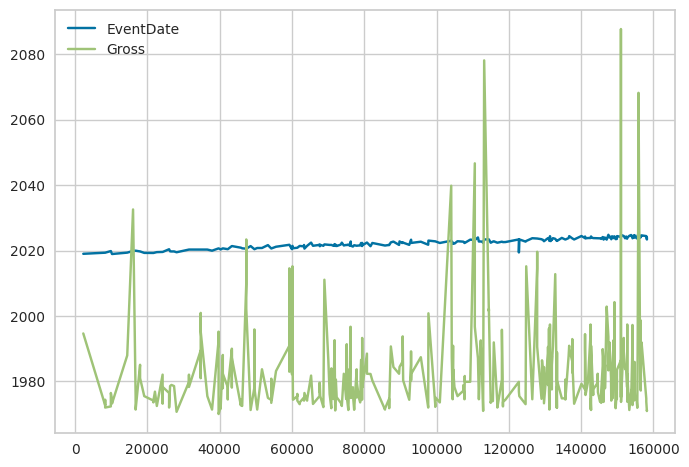

In [17]:
data.plot()

In [18]:
train_size = int(len(data)*0.7)
train,test = data[:train_size],data[train_size:]


In [19]:
from pycaret.time_series import *
s = setup(train, session_id = 123, target='Gross', html=False)


                                         Description                    Value
0                                         session_id                      123
1                                             Target                    Gross
2                                           Approach               Univariate
3                                Exogenous Variables                  Present
4                                Original data shape                 (424, 2)
5                             Transformed data shape                 (424, 2)
6                        Transformed train set shape                 (423, 2)
7                         Transformed test set shape                   (1, 2)
8                           Rows with missing values                     0.0%
9                                     Fold Generator  ExpandingWindowSplitter
10                                       Fold Number                        3
11                       Enforce Prediction Interval            

In [20]:
# import TSForecastingExperiment and init the class
from pycaret.time_series import TSForecastingExperiment
exp = TSForecastingExperiment()

In [21]:
# check the type of exp
type(exp)

pycaret.time_series.forecasting.oop.TSForecastingExperiment

In [29]:
# init setup on exp
exp.setup(train, fh = 3, target = 'Gross', session_id = 123)


,Description,Value
0,session_id,123
1,Target,Gross
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(424, 2)"
5,Transformed data shape,"(424, 2)"
6,Transformed train set shape,"(421, 2)"
7,Transformed test set shape,"(3, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [30]:
# check statistical tests on original data
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,424.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,4430.373821
3,Summary,Statistics,Transformed,Median,,3575.0
4,Summary,Statistics,Transformed,Standard Deviation,,4153.589048
5,Summary,Statistics,Transformed,Variance,,17252301.981086
6,Summary,Statistics,Transformed,Kurtosis,,16.762521
7,Summary,Statistics,Transformed,Skewness,,3.139147
8,Summary,Statistics,Transformed,# Distinct Values,,177.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",85.620086


In [31]:
# compare baseline models
best = compare_models()

In [34]:
# compare models using OOP
exp.compare_models()


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

[]

No such comm: 12daa206637443c496dc19d6ad4c2afe


In [26]:
# check available models
models()


,Name,Reference,Turbo
ID,,,
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
croston,Croston,sktime.forecasting.croston.Croston,True
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseaso...,pycaret.containers.models.time_series.BaseCdsD...,True
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detren...,pycaret.containers.models.time_series.BaseCdsD...,True


In [33]:
compare_ts_models = compare_models(include = ['arima'])